# Jan Izydorczyk

# Sprawozdanie 7

In [5]:
from matplotlib import pyplot as plt
import math
import numpy as np
import random
import scipy
import sys
%matplotlib notebook

print("Wersja Pythona:")
print (sys.version)
print(f"Wersja numpy: {np.__version__}")
print("Konfiguracja liczb zmiennoprzecinkowych")
print(sys.float_info)

f64 = np.float64
f32 = np.float32

Wersja Pythona:
3.9.4 (tags/v3.9.4:1f2e308, Apr  6 2021, 13:40:21) [MSC v.1928 64 bit (AMD64)]
Wersja numpy: 1.20.2
Konfiguracja liczb zmiennoprzecinkowych
sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)


In [6]:
import networkx as nx
import graphviz as gv

 # Zadanie 1

In [7]:
A1 = np.array([
     [7, 1, -1, 2],
     [1, 8, 0, -2],
     [-1, 0, 4, -1],
     [2, -2, -1, 6]
 ], dtype=f64)
b1 = np.array([3, -5, 4, -3], dtype=f64)
b1.shape=(-1, 1)
sol1 = np.linalg.solve(A1, b1)
E1 = (A1, b1, sol1)

In [8]:
 A2 = np.array([
     [7, 3, -1, 2],
     [3, 8, 1, -4],
     [-1, 1, 4, -1],
     [2, -4, -1, 6]
 ], dtype=f64)
b2 = np.array([-1, 0, -3, 1], dtype=f64)
b2.shape=(-1, 1)
sol2 = np.linalg.solve(A2, b2)
E2 = (A2, b2, sol2)

In [17]:
def remove_zeros_from_diagonal(M):
    M = np.copy(M)
    for idx in range(M.shape[0]):
        max_idx = np.argmax(M[idx:, idx]) + idx
        M[[idx, max_idx]] = M[[max_idx, idx]]
    return M

In [18]:
M = np.array([
    [2, 1, 3],
    [1, 2, 4],
    [3, 1, 4]
])
remove_zeros_from_diagonal(M)

array([[3, 1, 4],
       [1, 2, 4],
       [2, 1, 3]])

In [28]:
def solver_(method):
    def wrapper(A, b, sol, epsilon, *args, x_t=None, max_steps=None, epsilons_buf=None,  **kwargs):
        A = remove_zeros_from_diagonal(A)
        if x_t is None:
            x_t = np.random.rand(*b.shape)
        def pred(x,steps):
            nonlocal epsilon, sol
            if sol is not None:
                return not np.allclose(x_t, sol, atol=epsilon)
            elif max_steps is not None:
                return steps < max_steps
            return False
        return method(A, B, sol, epsilon, *args, x_t=x_t, max_steps=max_steps, epsilons_buf=epsilons_buf,  **kwargs)

## Metoda Jacobiego 

In [27]:
def solve_jacoby(A, b, sol, epsilon, x_t=None, max_steps=None, epsilons_buf=None, pred=None):
    # M = I - B^-1 * A 
    # W = B^-1 * b
    A = remove_zeros_from_diagonal(A)
    n = A.shape[0]
    A = np.copy(A)
    D_1 = np.diag(1 / np.diag(A))
    M = np.eye(n) - D_1 @ A
    W = D_1 @ b
    if x_t is None:
        x_t = np.random.rand(*b.shape)
    steps = 0
    
#     while np.max(abs(x_t-sol)) > epsilon:
    while pred(x_t):
        steps += 1
        x_t = M @ x_t + W
        if sol is not None and epsilons_buf is not None:
            epsilons_buf.append(np.mean(x_t - sol))
    return x_t, steps

In [20]:
 solve_jacoby(*E1, epsilon=1e-7, x_t=None)

(array([[ 0.99999623],
        [-0.99999637],
        [ 1.00000049],
        [-0.99999433]]),
 18)

In [7]:
 solve_jacoby(*E2, epsilon=1e-7, x_t=None)

(array([[-0.99999197],
        [ 0.99999074],
        [-0.99999783],
        [ 0.99999032]]),
 86)

## Metoda Gaussa-Seidla

In [21]:
def solve_gauss_seidl(A, b, sol, epsilon, x_t=None):
    # M = I - B^-1 * A 
    # W = B^-1 * b
    # B = L + D
    A = remove_zeros_from_diagonal(A)
    if x_t is None:
        x_t = np.random.rand(*b.shape)
    n = A.shape[0]
    steps = 0
    while not np.allclose(x_t, sol, atol=epsilon):
        steps += 1
        for i in range(n):
            x_t[i, 0] = (b[i, 0] - np.dot(A[i, :], x_t ) + A[i,i]*x_t[i, 0] ) / A[i,i]
    return x_t, steps

In [22]:
print(solve_gauss_seidl(*E1, 1e-7))

(array([[ 0.99999138],
       [-0.99999302],
       [ 1.00000375],
       [-0.99999417]]), 9)


In [23]:
print(solve_gauss_seidl(*E2, 1e-4))

(array([[-0.99989689],
       [ 0.9998906 ],
       [-0.99998067],
       [ 0.99989592]]), 36)


## Metoda SOR

In [24]:
def solve_sor(A, b, sol, omega, epsilon, x_t=None):
    # M = I - B^-1 * A 
    # W = B^-1 * b
    # B = L + D
    A = remove_zeros_from_diagonal(A)
    if x_t is None:
        x_t = np.random.rand(*b.shape)
    n = A.shape[0]
    steps = 0
    while not np.allclose(x_t, sol, atol=epsilon):
        steps += 1
        for i in range(n):
            x_t[i, 0] = (1 - omega) * x_t[i, 0] + omega * (b[i, 0] - np.dot(A[i, :], x_t ) + A[i,i]*x_t[i, 0] ) / A[i,i]
    return x_t, steps

In [25]:
solve_sor(*E1, omega=1.1, epsilon=1e-7)

(array([[ 0.99999858],
        [-0.99999952],
        [ 0.99999993],
        [-0.99999781]]),
 6)

In [26]:
solve_sor(*E2, omega=1.4, epsilon=1e-7)

(array([[-1.00000079],
        [ 0.99999977],
        [-1.00000454],
        [ 0.99999805]]),
 14)

# Zadanie 2

In [151]:
from graphviz import Digraph

from itertools import chain

def circuit_graph(edges, E):
    print()
    H = nx.DiGraph()
    beg = (E[0], E[1])
    for a, b, w in edges:
        H.add_edge(a, b)
        H.add_edge(b, a)
        H[a][b]['weight'] = w
        H[b][a]['weight'] = -w
        if (a, b) == beg or (b, a) == beg:
            H[a][b]['cur'] = E[2]
            H[b][a]['cur'] = -E[2]
    return H
   

In [177]:
def draw_circuit(H):
    if isinstance(H, nx.DiGraph):
        H = H.to_undirected()
        for a, b in H.edges:
            H[a][b]['weight'] = abs(H[a][b]['weight'])
    pos=nx.spring_layout(H)
    edge_labels=dict([((u,v,),np.round(d['weight'], 2))for u,v,d in H.edges(data=True)])
    nx.draw_networkx_edge_labels(H,pos,edge_labels=edge_labels)
    nx.draw_networkx(H, pos)


In [153]:
C = circuit_graph([
    (2, 4, 7),
    (2, 3, 2),
    (2, 5, 5),
    (3, 6, 4),
    (3, 4, 6),
    (4, 5, 11),
    (4, 6, 9),
    (5, 6, 1),
], (2, 4, 300))

In [172]:

def solve_circuit(C, solver):
    uC = C.to_undirected()
    cycles = nx.algorithms.cycles.cycle_basis(uC)
    
    to_idx_dict = dict(zip(uC.edges, range(len(uC.edges))))
    n = len(to_idx_dict)
    def to_idx(a,b):
        nonlocal to_idx_dict
        return to_idx_dict.get((a, b), to_idx_dict.get((b, a)))
    
    M = np.zeros((n, n))
    Y = np.zeros((n, 1))
    for idx, c in enumerate(cycles):
        for i in range(len(c)):
            a, b = c[i], c[(i+1)%len(c)]
            if 'cur' in C[a][b]:
                Y[idx] = C[a][b]['cur']
            M[idx][to_idx(a, b)] = C[a][b]['weight']
    idx = len(cycles)
    for v, idx in zip(C.nodes, range(len(cycles),  n)):
        for nbor in uC.neighbors(v):
            M[idx][to_idx(v, nbor)] = np.sign(C[v][nbor]['weight'])
    
    X = solver(M, Y)
    
    G = nx.Graph()
    for (a, b), idx in to_idx_dict.items():
        G.add_edge(a, b)
        G[a][b]['weight'] = abs(X[idx]) 
    return G
    
    

In [173]:
C_I = solve_circuit(C, np.linalg.solve)

<IPython.core.display.Javascript object>


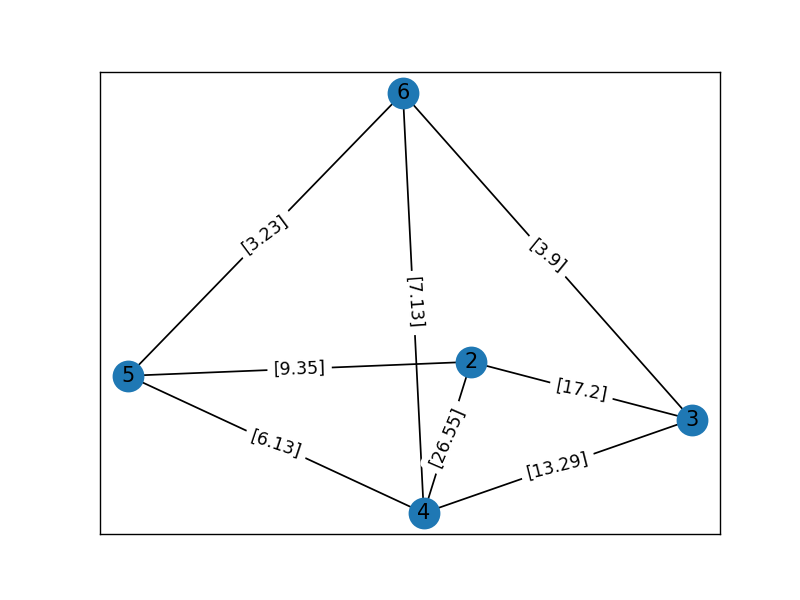

In [178]:
draw_circuit(C_I)